In [1]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
import pytorch_lightning as pl
import os

DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")

In [2]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(
            (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
            [0.24703223, 0.24348513, 0.26158784]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
        [0.24703223, 0.24348513, 0.26158784]),
    ]
)

train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=test_transform, download=True)
test_set = CIFAR10(
    root=DATASET_PATH, train=False, transform=test_transform,download=True)

100%|██████████| 170M/170M [00:20<00:00, 8.12MB/s] 


In [4]:
import torch
import torch.utils.data as data

pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

Seed set to 42


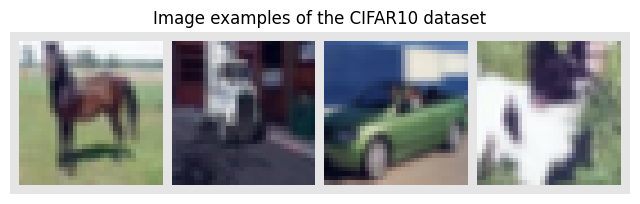

In [5]:
import matplotlib.pyplot as plt
import torchvision

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack(
    [val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(
    CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [6]:
train_loader = data.DataLoader(
    train_set, batch_size=16,
    shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = data.DataLoader(
    val_set, batch_size=16,
    shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(
    test_set, batch_size=16,
    shuffle=False, drop_last=False, num_workers=0)